In [1]:
import sys, os
import sparse
import xsimlab as xs
import numpy as np
import pandas as pd
import igraph as ig

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.fruit import fruit as model

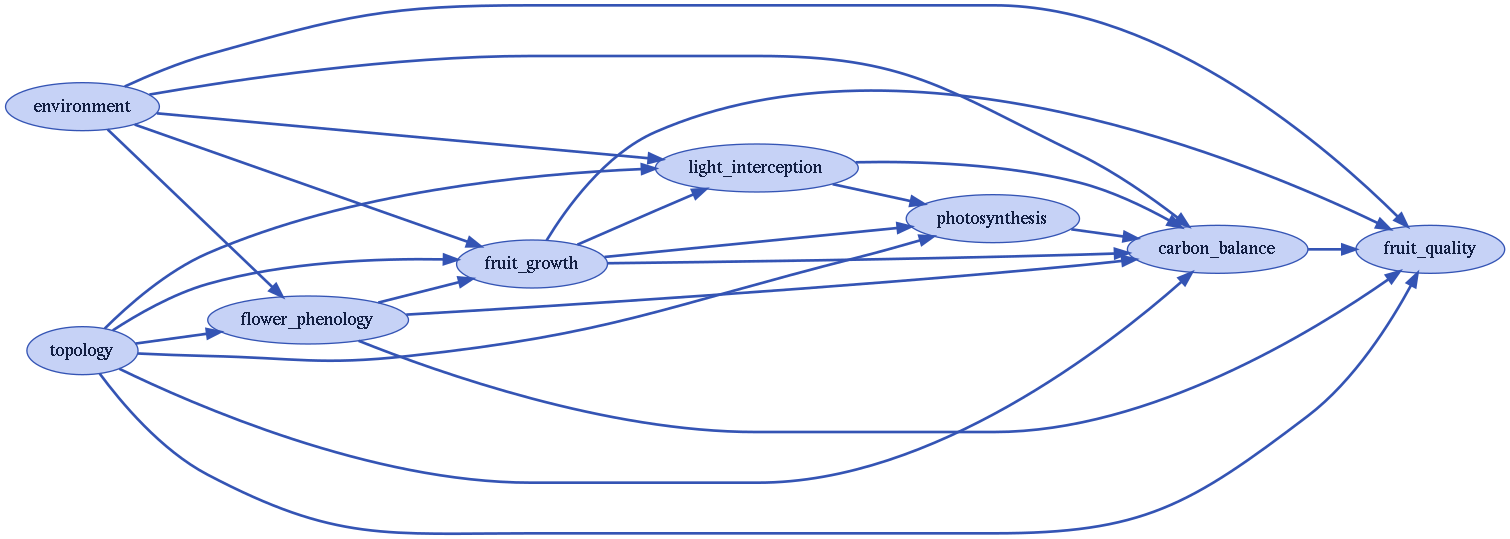

In [3]:
model.visualize(show_inputs=False, show_variables=False)

In [4]:
nb_leaves = [5, 10, 25, 50, 100, 150, 300, 500] # original fruit model publication, here a gu is a branch already
nb_gus = len(nb_leaves)
g = ig.Graph.Tree(nb_gus, 2, mode=ig.TREE_OUT)
adjacency = np.array(g.get_adjacency().data)

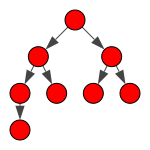

In [5]:
ig.plot(g, bbox=(0,0,150,150), layout=g.layout_reingold_tilford())

In [6]:
ds = vmlab.create_setup(
    model=model,
    setup_toml='../share/setup/fruit_model.toml',
    clocks={
        'day': pd.date_range(start='2002-12-01', end='2003-03-31', freq="1d"),
        'week': pd.date_range(start='2002-12-01', end='2003-03-31', freq="1W")
    },
    main_clock='day',
    input_vars={
        'topology': {
            'adjacency': adjacency,
            'nb_leaves': nb_leaves
        },
        'fruit_growth': {
            'nb_fruits_ini': np.ones(nb_gus)
        },
        'flower_phenology': {
            'bloom_date': np.full(nb_gus, '2002-11-30')
        },
        'carbon_balance': {
            'DM_fruit': np.zeros(nb_gus)
        },
    },
    output_vars='day'
)

In [7]:
ds

<xarray.Dataset>
Dimensions:                                  (GU: 8, day: 121, week: 18)
Coordinates:
  * day                                      (day) datetime64[ns] 2002-12-01 ...
  * week                                     (week) datetime64[ns] 2002-12-01...
Dimensions without coordinates: GU
Data variables:
    topology__adjacency                      (GU, GU) int64 0 1 1 0 ... 0 0 0 0
    topology__nb_leaves                      (GU) int64 5 10 25 ... 150 300 500
    fruit_growth__nb_fruits_ini              (GU) float64 1.0 1.0 ... 1.0 1.0
    flower_phenology__bloom_date             (GU) <U10 '2002-11-30' ... '2002...
    carbon_balance__DM_fruit                 (GU) float64 0.0 0.0 ... 0.0 0.0
    carbon_balance__parameter_file_path      <U48 '../share/setup/../paramete...
    environment__parameter_file_path         <U45 '../share/setup/../paramete...
    fruit_growth__parameter_file_path        <U46 '../share/setup/../paramete...
    fruit_quality__parameter_file_path       <U47 '../share/setup/../paramete...
    light_interception__parameter_file_path  <U52 '../share/setup/../paramete...
    photosynthesis__parameter_file_path      <U48 '../share/setup/../paramete...
    flower_phenology__parameter_file_path    <U43 '../share/setup/../paramete...
Attributes:
    __xsimlab_output_vars__:  environment__parameter_file_path,flower_phenolo...

In [8]:
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar()])

             0% | initialize 

In [9]:
ds_out

<xarray.Dataset>
Dimensions:                                  (GU: 8, day: 121, hour: 24, week: 18)
Coordinates:
  * GU                                       (GU) <U10 'Branch0' ... 'Branch7'
  * day                                      (day) datetime64[ns] 2002-12-01 ...
  * hour                                     (hour) int8 0 1 2 3 ... 20 21 22 23
  * week                                     (week) datetime64[ns] 2002-12-01...
Data variables:
    carbon_balance__DM_fruit                 (day, GU) float64 0.0 0.0 ... 82.81
    carbon_balance__DM_fruit_delta           (day, GU) float64 0.0 ... 0.01522
    carbon_balance__DM_structural_leaf       (day, GU) float64 0.0 0.0 ... 370.4
    carbon_balance__DM_structural_stem       (day, GU) float64 53.66 ... 53.66
    carbon_balance__MR_fruit                 (day, GU) float64 0.0 0.0 ... 0.139
    carbon_balance__MR_leaf                  (day, GU) float64 0.0 0.0 ... 1.372
    carbon_balance__MR_repro                 (day, GU) float64 0.0 0.0 ... 0.139
    carbon_balance__MR_stem                  (day, GU) float64 0.0 ... 0.07315
    carbon_balance__MR_veget                 (day, GU) float64 0.0 0.0 ... 1.445
    carbon_balance__assimilates              (day, GU) float64 0.04289 ... 2.378
    carbon_balance__parameter_file_path      <U48 '../share/setup/../paramete...
    carbon_balance__remains_1                (day, GU) float64 0.04289 ... 0....
    carbon_balance__remains_2                (day, GU) float64 0.04289 ... 0....
    carbon_balance__remains_3                (day, GU) float64 0.04289 ... 0....
    carbon_balance__required_DM_fruit        (day, GU) float64 0.0 0.0 ... 0.0
    carbon_balance__reserve_leaf             (day, GU) float64 0.0 0.0 ... 26.67
    carbon_balance__reserve_leaf_max         (day, GU) float64 0.0 0.0 ... 0.0
    carbon_balance__reserve_mob              (day, GU) float64 0.04289 ... 0....
    carbon_balance__reserve_nmob_leaf        (day, GU) float64 0.0 0.0 ... 25.9
    carbon_balance__reserve_nmob_stem        (day, GU) float64 2.573 ... 1.581
    carbon_balance__reserve_stem             (day, GU) float64 2.616 ... 1.607
    environment__GR                          (day, hour) float64 0.0 0.0 ... 0.0
    environment__RH                          (day, hour) float64 88.0 ... 83.0
    environment__TM                          (day) float64 25.45 24.65 ... 25.9
    environment__TM_air                      (day, hour) float64 25.1 ... 25.9
    environment__T_air                       (day, hour) float64 22.6 ... 19.6
    environment__T_fruit                     (day, hour) float64 25.1 ... 25.9
    environment__parameter_file_path         <U45 '../share/setup/../paramete...
    flower_phenology__DAB                    (day, GU) float64 1.0 1.0 ... 120.0
    flower_phenology__bloom_date             (GU) datetime64[D] 2002-11-30 .....
    flower_phenology__dd_cum                 (day, GU) float64 9.45 ... 1.206...
    flower_phenology__dd_delta               (day, GU) float64 9.45 9.45 ... 9.9
    flower_phenology__parameter_file_path    <U43 '../share/setup/../paramete...
    fruit_growth__DM_fruit_0                 (GU) float64 13.0 13.0 ... 13.0
    fruit_growth__DM_fruit_max               (day, GU) float64 0.0 0.0 ... 82.94
    fruit_growth__D_fruit                    (day, GU) float64 0.0 ... 0.007063
    fruit_growth__nb_fruits                  (day, GU) float64 0.0 0.0 ... 1.0
    fruit_growth__nb_fruits_ini              (GU) float64 1.0 1.0 ... 1.0 1.0
    fruit_growth__parameter_file_path        <U46 '../share/setup/../paramete...
    fruit_quality__DM_flesh                  (day, GU) float64 0.0 0.0 ... 55.83
    fruit_quality__DM_fleshpeel              (day, GU) float64 0.0 0.0 ... 67.87
    fruit_quality__FM_fruit                  (day, GU) float64 0.0 0.0 ... 417.8
    fruit_quality__W_flesh                   (day, GU) float64 0.0 0.0 ... 274.4
    fruit_quality__W_fleshpeel               (day, GU) float64 0.0 0.0 ... 306.3
    fruit_quality__

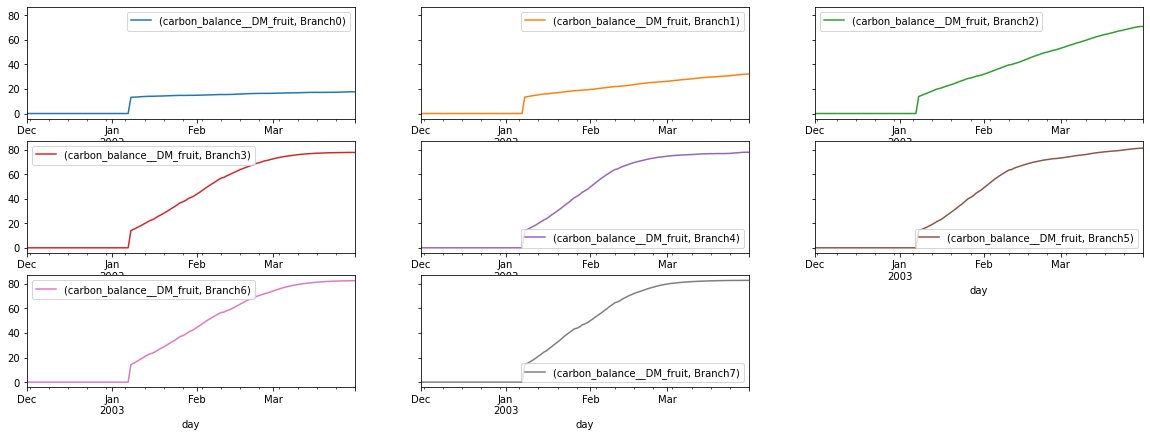

In [10]:
_ = ds_out.carbon_balance__DM_fruit.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

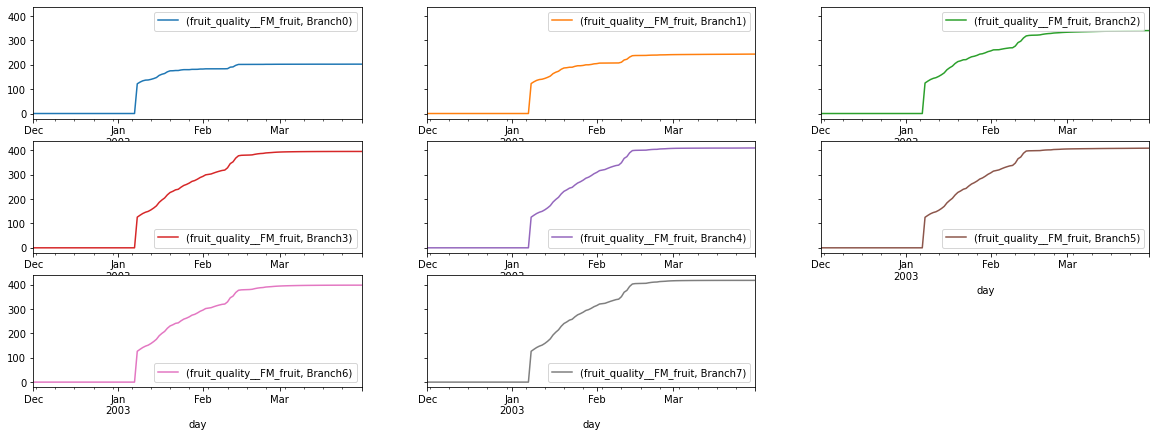

In [11]:
_ = ds_out.fruit_quality__FM_fruit.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

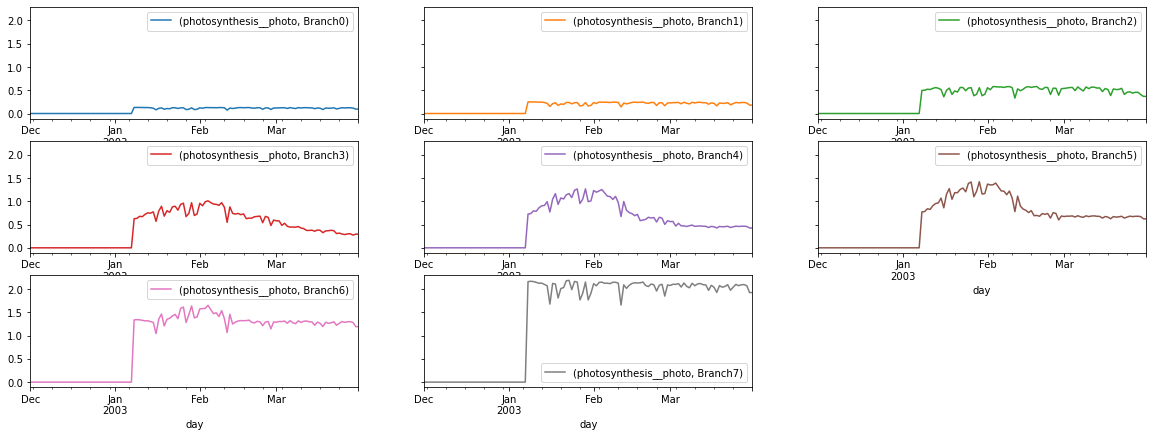

In [12]:
_ = ds_out.photosynthesis__photo.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

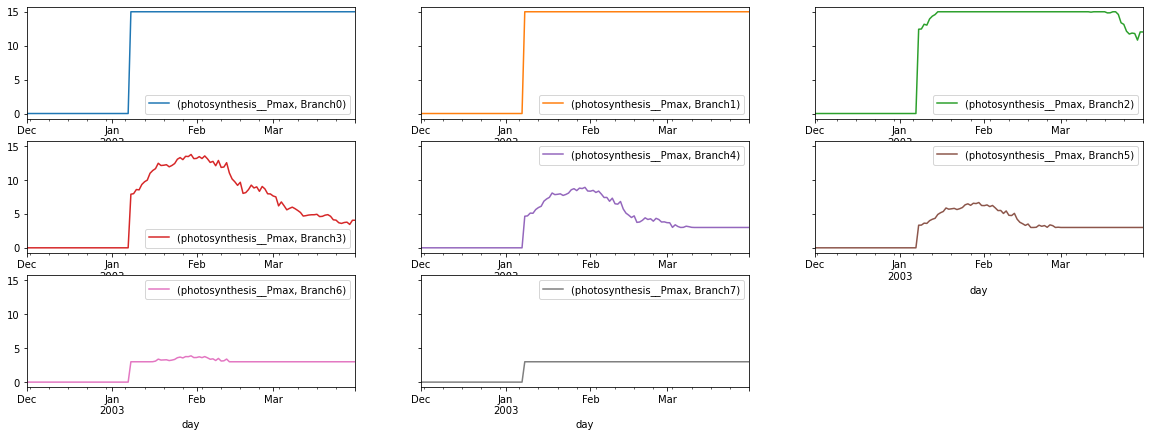

In [13]:
_ = ds_out.photosynthesis__Pmax.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

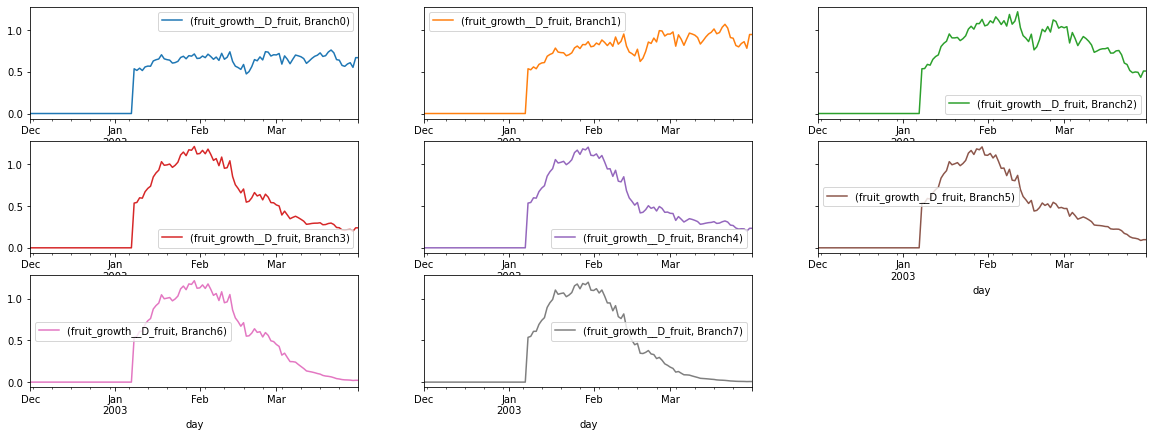

In [14]:
_ = ds_out.fruit_growth__D_fruit.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

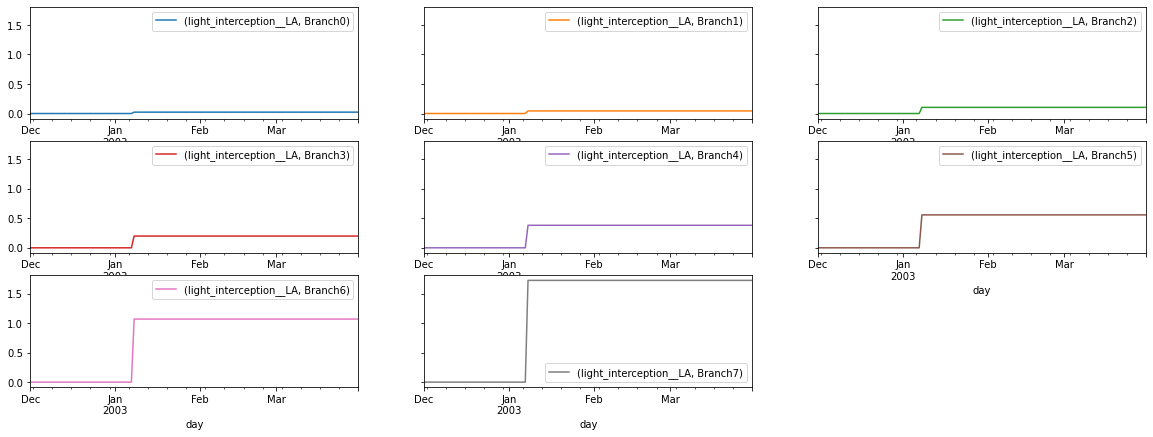

In [15]:
_ = ds_out.light_interception__LA.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

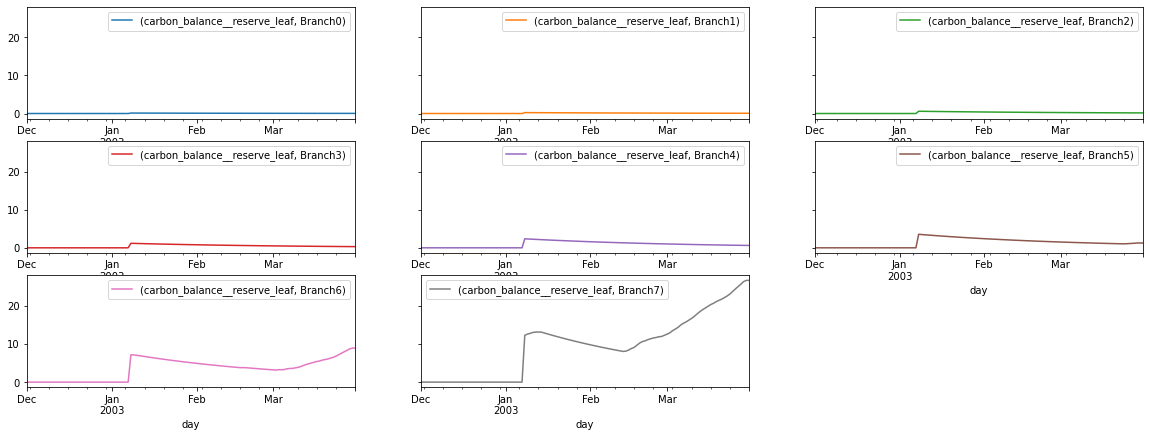

In [16]:
_ = ds_out.carbon_balance__reserve_leaf.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

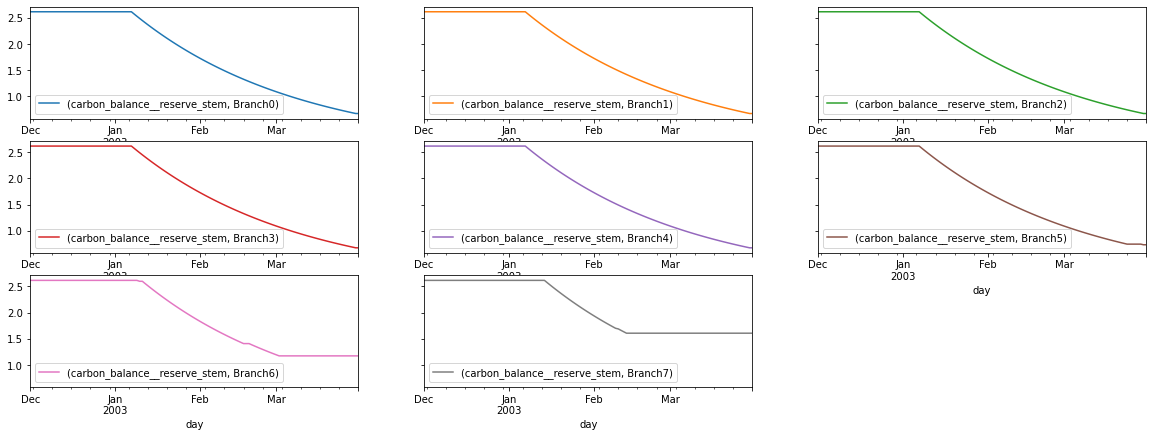

In [17]:
_ = ds_out.carbon_balance__reserve_stem.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

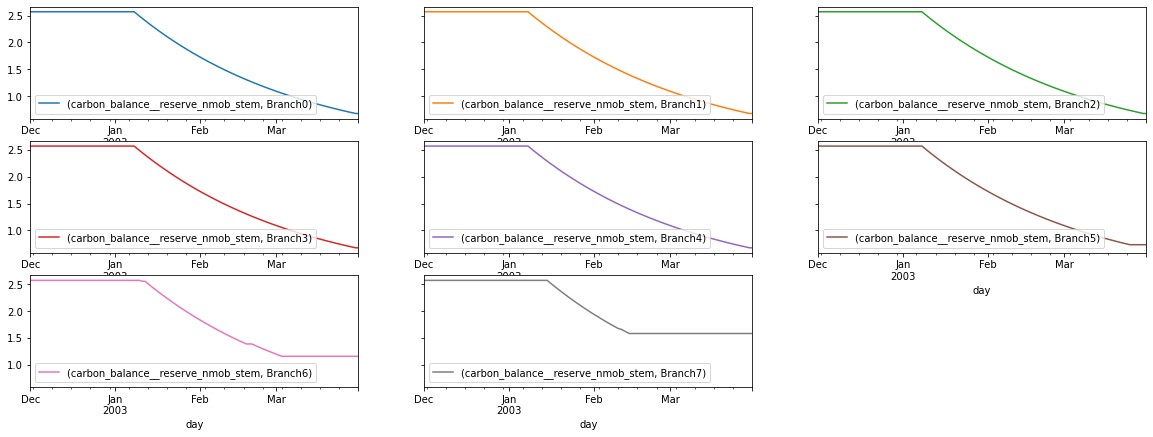

In [27]:
_ = ds_out.carbon_balance__reserve_nmob_stem.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

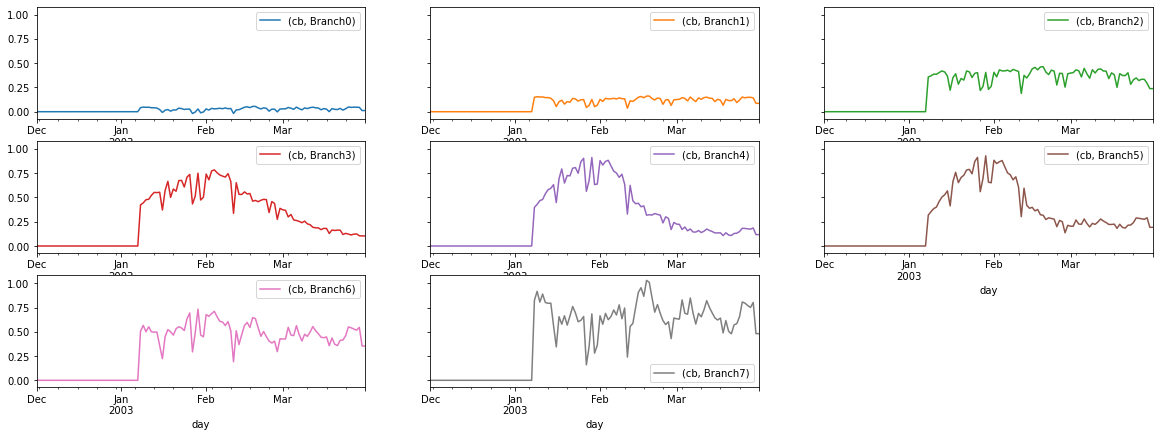

In [18]:
_ = (ds_out.photosynthesis__photo - ds_out.carbon_balance__MR_veget) \
    .to_dataframe('cb').unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

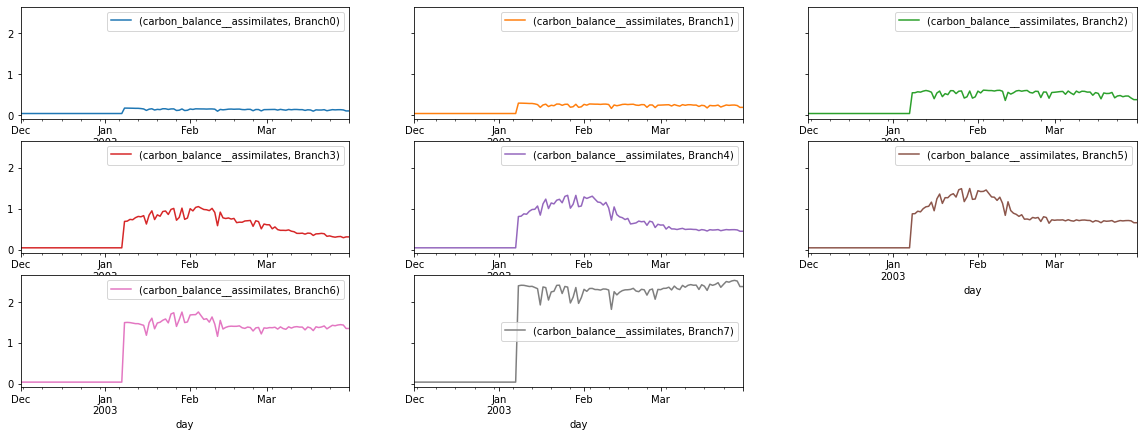

In [19]:
_ = ds_out.carbon_balance__assimilates.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

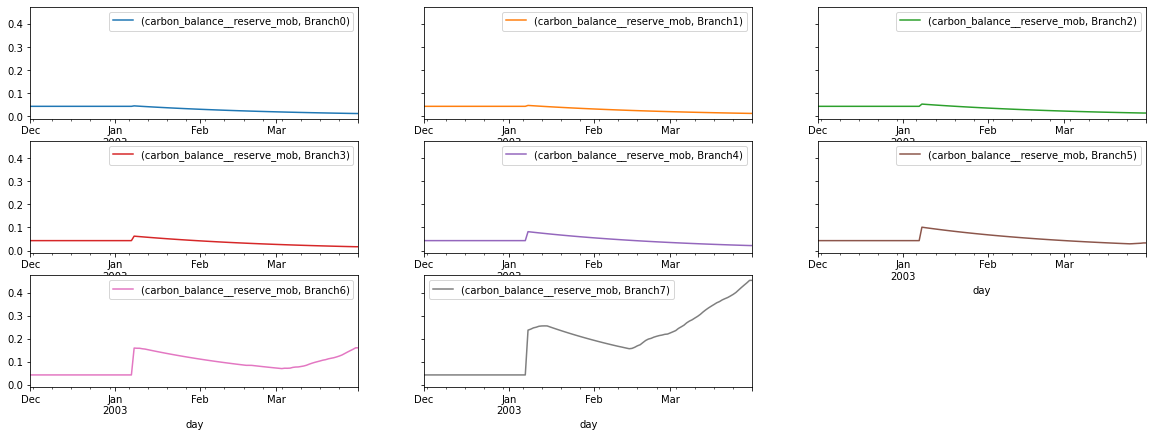

In [20]:
_ = ds_out.carbon_balance__reserve_mob.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

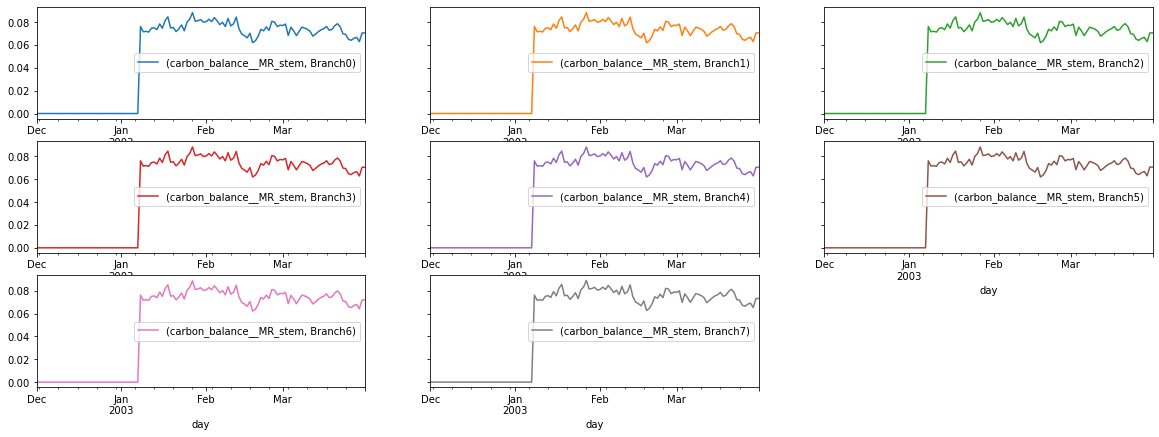

In [21]:
_ = ds_out.carbon_balance__MR_stem.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

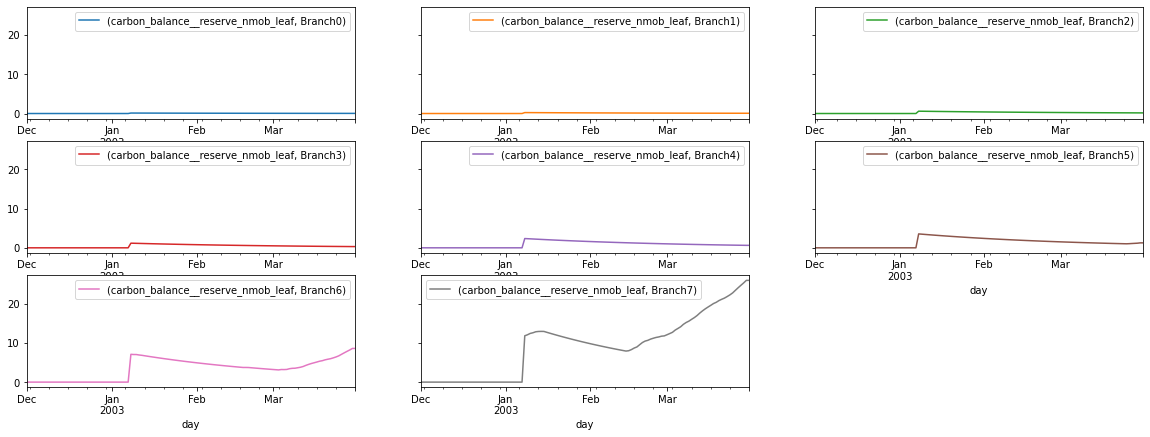

In [22]:
_ = ds_out.carbon_balance__reserve_nmob_leaf.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

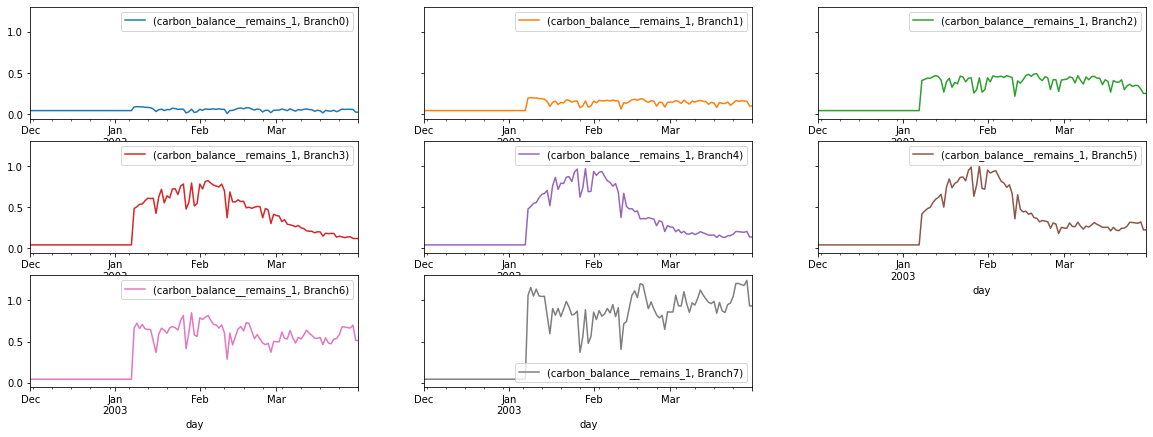

In [23]:
_ = ds_out.carbon_balance__remains_1.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

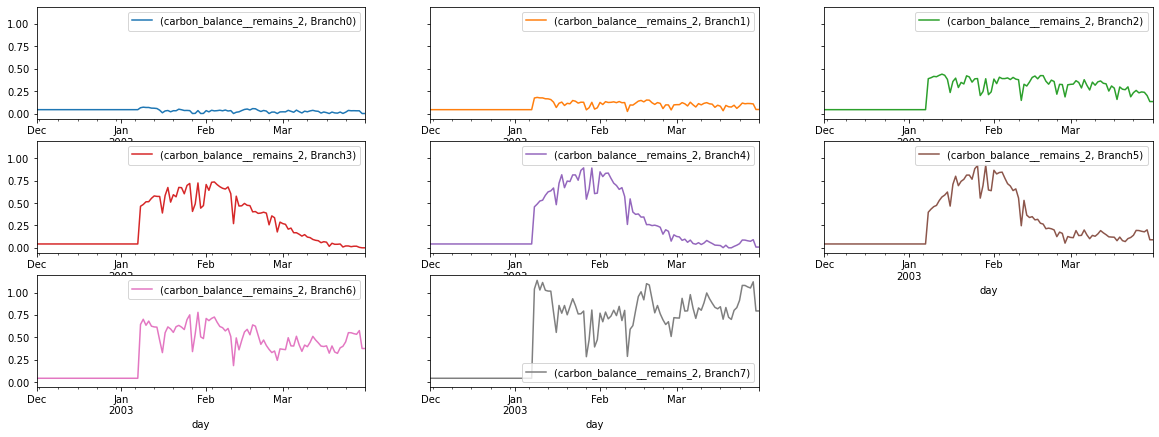

In [24]:
_ = ds_out.carbon_balance__remains_2.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

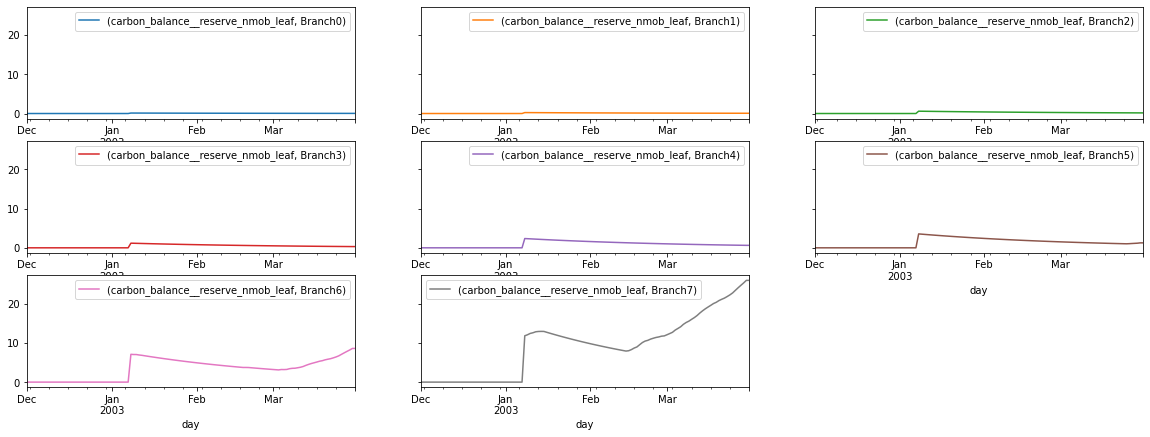

In [25]:
_ = ds_out.carbon_balance__reserve_nmob_leaf.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

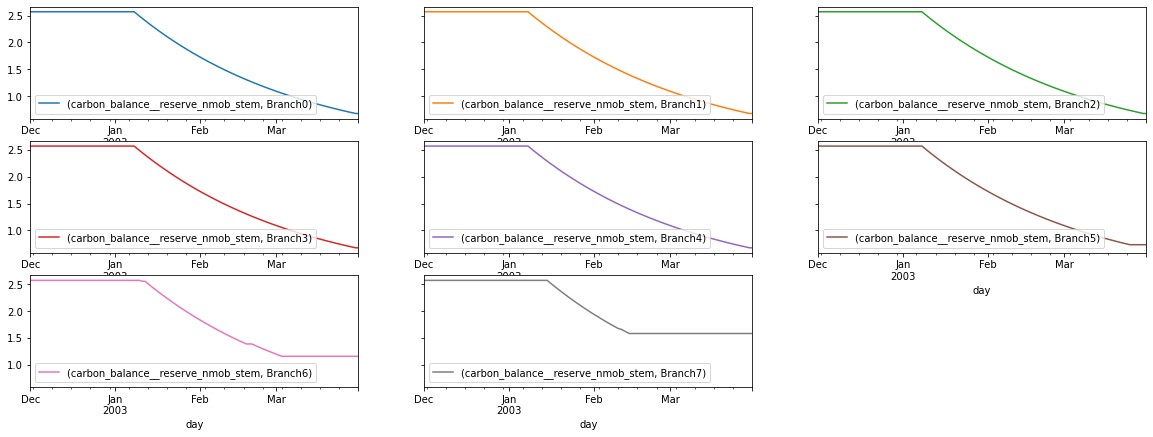

In [26]:
_ = ds_out.carbon_balance__reserve_nmob_stem.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

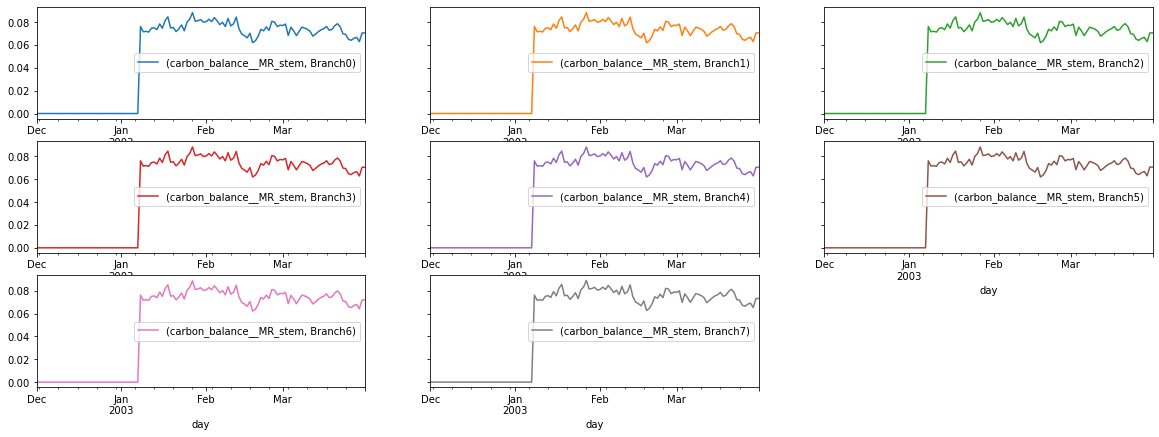

In [28]:
_ = ds_out.carbon_balance__MR_stem.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

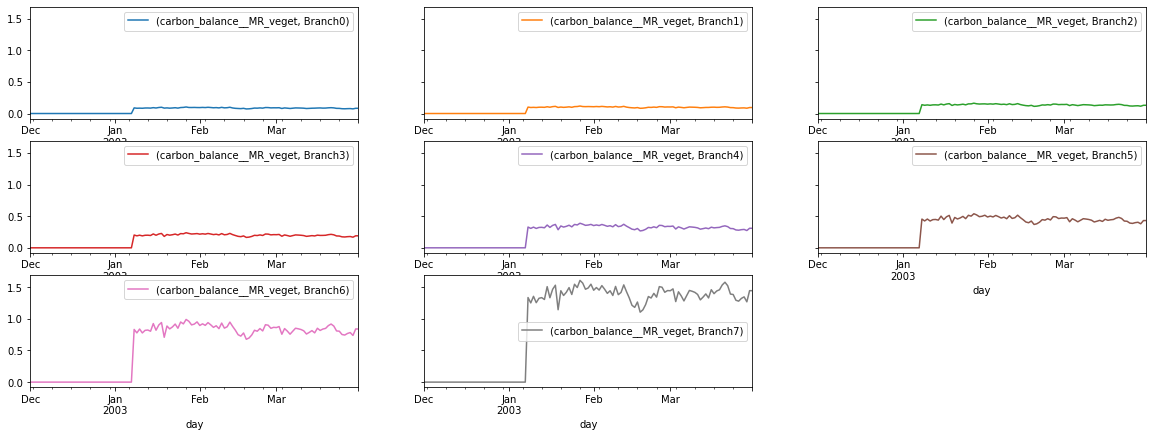

In [31]:
_ = ds_out.carbon_balance__MR_veget.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)

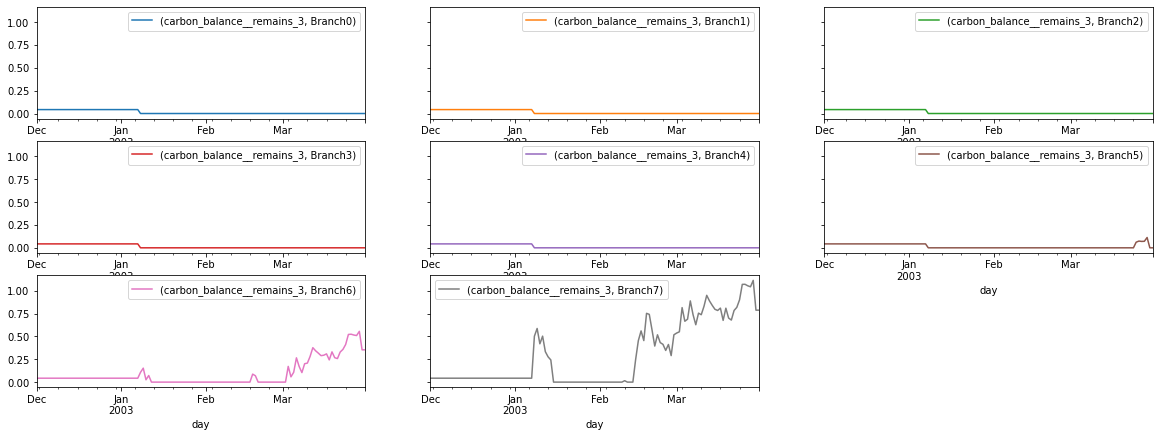

In [32]:
_ = ds_out.carbon_balance__remains_3.to_dataframe().unstack(level='GU').plot(subplots=True, layout=(nb_gus//3+1,3), figsize=(20,7), sharex=False, sharey=True)